# Azure OpenAI Assistant API Mutli-Agent Example

## Setups

Install the required packages using pip. 

In [ ]:
# %pip install -r requirements.txt

## Imports and environment variables

It's best practice to keep your secrets and keys in an environment variable file. You can do this by editing the "sample.env" file and renaming it to ".env".

In [2]:
import io
import os
import time
from datetime import datetime
from typing import Iterable
from matplotlib import pyplot as plt  
import cv2

from dotenv import load_dotenv
from openai import AzureOpenAI
from openai.types.beta.threads.message_content_image_file import MessageContentImageFile
from openai.types.beta.threads.message_content_text import MessageContentText
from openai.types.beta.threads.messages import MessageFile

import base64
from mimetypes import guess_type
from getpass import getpass

load_dotenv()

api_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
api_key = os.getenv("AZURE_OPENAI_KEY")
api_version = os.getenv("AZURE_OPENAI_API_VERSION")

# name of the AOAI model deployment that is compatible with the Assistants API you want to use
api_deployment_name = os.getenv("GPT4_DEPLOYMENT_NAME")

# name of the model deployment for GPT 4 with Vision
api_deployment_name_vision = os.getenv("GPT4_VISION_DEPLOYMENT_NAME")

# name of the model deployment for DALL·E 3
api_deployment_name_dalle = os.getenv("DALLE3_DEPLOYMENT_NAME")

client = AzureOpenAI(api_key=api_key, api_version=api_version, azure_endpoint=api_endpoint)

## Image Generator Assistant

This agent is responsible for generating images using a prompt to the Dalle-3 Model. The output is a .jpg file stored in the users local directory.


#Image generator agent definition.

- Assistant name = the name of the agent
- Assistant instructions = description of the agent
- Function = functions the agents has access to

In [3]:
name_dl = "dalle_assistant"
instructions_dl = """As a top-tier image generator AI, you are adept at creating accurate imaged from a prompt. You will properly create an image from the prompt. Ensure to execute the necessary image generation before responding to the user."""

tools = [
    {
        "type": "function",
        "function": {
            "name": "generate_image",
            "description": "Creates and displays an image",
            "parameters": {
                "type": "object",
                "properties": {
                    "prompt": {
                        "type": "string",
                        "description": "The prompt to be used to create the image",
                    }
                },
                "required": ["prompt"],
            },
        },
    }
]

verbose_output = True


## Agent Initialization

Initializes the agent with the definition described above

In [4]:

dalle_assistant = client.beta.assistants.create(
  name=name_dl,
  instructions=instructions_dl,
  model=api_deployment_name,
  tools=tools
)

## Image Generator "generate_image" function

This function calls the Dalle-3 image generator given the prompt

In [5]:
from typing import List  
import requests  
import base64  
from io import BytesIO  
from PIL import Image  
import os  
import urllib.request  
from pathlib import Path  
import cv2  
from matplotlib import pyplot as plt  
  
def generate_image(prompt: str) -> str:  
    """  
    Call the Azure OpenAI Dall-e 3 model to generate an image from a text prompt.  
    Executes the call to the Azure OpenAI Dall-e 3 image creator, saves the file into the local directory, and displays the image.  
  
    @param prompt_str: The prompt to be used to generate the image  
    @return: returns the file path of the file  
    """  
    response = client.images.generate(  
        model="Dalle3",  
        prompt=prompt,  
        size="1024x1024",  
        quality="standard",  
        n=1  
    )  
  
    # Retrieve the image URL from the response (assuming response structure)  
    image_url = response.data[0].url  
  
    # Open the image from the URL and save it to a temporary file.  
    im = Image.open(requests.get(image_url, stream=True).raw)  
  
    # Define the filename and path where the image should be saved.  
    filename = "temp.jpg"  
    local_path = Path(filename)  
  
    # Save the image.  
    im.save(local_path)  
  
    # Get the absolute path of the saved image.  
    full_path = str(local_path.absolute())  
    
    img = cv2.imread('temp.jpg', cv2.IMREAD_UNCHANGED)  
    
    # Convert the image from BGR to RGB for displaying with matplotlib,  
    # because OpenCV uses BGR by default and matplotlib expects RGB.  
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    
    # Display the image with matplotlib.  
    plt.imshow(img_rgb)  
    plt.axis('off')  # Turn off axis labels.  
    plt.show()  

    # Return the full path of the saved image.  
    print("Dalle Assistant Message: " + full_path)
    return full_path  


# Vision Assistant

This agent is responsible for analyzing images. The output is a new prompt to be used by the image creator agent.


#Vision assistant definition.

- Assistant name = the name of the agent
- Assistant instructions = description of the agent
- Function = functions the agents has access to

In [6]:
name_vs = "vision_assistant"
instructions_vs = """As a top-tier image analyzer AI, you are adept at analyzing and criticizing images to enhance them. You will properly analyze an image. Ensure to execute the necessary image analyzes are performed before responding to the user."""

tools = [
    {
        "type": "function",
        "function": {
            "name": "analyze_image",
            "description": "analyzes and critics an image",
            "parameters": {
                "type": "object",
                "properties": {
                    "image_filename": {
                        "type": "string",
                        "description": "The local image file name including the full path",
                    }
                },
                "required": ["image_filename"],
            },
        },
    }
]

verbose_output = True


## Agent Initialization

Initializes the agent with the definition described above

In [7]:
vision_assistant = client.beta.assistants.create(
    name=name_vs,
    instructions=instructions_vs,
    model=api_deployment_name,
    tools=tools
)

## Vision Assistant "analyze_image" function

This function calls the GPT4 Vision image analyzes given an image

In [8]:
from typing import List
import requests  
import base64  
from io import BytesIO  
from PIL import Image 
import os
import urllib.request


def analyze_image(image_filename: str) -> str:
    """
    Call the Azure OpenAI GPT4 Vision model to analyze and critic an image and return the result.The resulting output should be a new prompt for dall-e that enhances the image based on the criticism and analysis

    @param prompt_str: The prompt to be used to analyze the image
    @return: returns the analyzes of the image into a prompt for dalle-3

    """
    import base64
    base64_image = base64.b64encode(open("temp.jpg", "rb").read()).decode("utf-8")

    content_images = [{"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}} for base64_image in [base64_image]]
    response = client.chat.completions.create(
    model="GPT4Vision",
    messages=[
        {
        "role": "user",
                "content": [
                {"type": "text", "text": "Analyze and critic this image and generate a new enhanced prompt for Dall-e with the criticism and analysis."}
            ] + content_images,
        }
    ],
    max_tokens=1000,
    )
    print("Vision Assistant Message: " + response.choices[0].message.content)
    return response.choices[0].message.content

## User Proxy

This agent facilitates the conversation between the user and other agents, ensuring successful completion of the task.


### Proxy Assistant definition.

- Assistant name = the name of the agent
- Assistant instructions = description of the agent including agents this user proxy has access to.
- Function = functions the agents has access to. send_message sends messages to the other agents and agent_name specifies which agent to communicate with

In [9]:

name_pa = "user_proxy"
instructions_pa = """As a user proxy agent, your responsibility is to streamline the dialogue between the user and specialized agents within this group chat.
Your duty is to articulate user requests accurately to the relevant agents and maintain ongoing communication with them to guarantee the user's task is carried out to completion.
Please do not respond to the user until the task is complete, an error has been reported by the relevant agent, or you are certain of your response.

You have access to the following agents to accomplish the task:
dalle_assistant to generate images, 
vision_assistant to analyze images, 

"""

tools = [
    {
        "type": "function",
        "function": {
            "name": "send_message",
            "description": "Send messages to other specialized agents in this group chat.",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "The message to be sent",
                    },
                    "agent_name": {
                        "type": "string",
                        "description": "The name of the agent to execute the task.",
                    }
                },
                "required": ["query"],
            },
        },
    }
]

verbose_output = True


## Agent Initialization

Initializes the agent with the definition described above

In [10]:
user_proxy = client.beta.assistants.create(
  name=name_pa,
  instructions=instructions_pa,
  model=api_deployment_name,
  tools=tools
)

### Proxy Assistant "send_message" function

This function calls the Assistant API to generate a main thread of communication between the agents listed in the agents_and_thread 

In [11]:
import subprocess  
from typing import Dict, Optional  

# Define a structure for the agents and threads
agents_and_threads: Dict[str, Dict[str, Optional[str]]] = {  
    "dalle_assistant": {  
        "agent": dalle_assistant, 
        "thread": None
    },
    "vision_assistant": {  
        "agent": vision_assistant, 
        "thread": None
    } 
}  

# Define the send_message function with only the query parameter  
def send_message(query: str, agent_name: str) -> str:  
    """
    Communicate with fellow specialized agents within this group chat by dispatching concise and clear messages detailing the tasks to be executed. Ensure that the essence of the task is conveyed, rather than delving into extensive procedural guidance.

    @param query: The content of the message intended for the other agent
    @return: The dispatched message
    """
    
    #Set the agent recipient 
    recipient_type = agent_name
    recipient_info = agents_and_threads[recipient_type] 
    
    #Create a new thread if user proxy and agent thread does not exist
    if not recipient_info["thread"]:  
        thread_object = client.beta.threads.create()  
        recipient_info["thread"] = thread_object  

    # This function dispatches a message to the proper agent and it's thread
    message = dispatch_message(query, recipient_info["agent"], recipient_info["thread"])  
    print("Proxy Assistant Message: " + message)
    return message  


## The main multi-agent communication flow

This agent facilitates the conversation between the user and other agents, ensuring successful completion of the task.


In [12]:
import time
import json

def dispatch_message(message, agent, thread):
    """
    Initiates execution of a series of tasks within a thread based on a given message and returns the result.

    This utility function dispatches a message to a designated thread, which in turn initiates a sequence of operations. These operations are encapsulated within an array of functions provided in the 'func' parameter. Each function is required to possess a 'run()' method that will execute and provide output upon completion.

    Parameters:

    message (str): The message that serves as the input for processing.
    agent (Azure OpenAI Assistant): The instance of the agent that will handle the processing of the message.
    thread (Thread): The OpenAI Assistants API thread that orchestrates the execution sequence.

    Returns:
    str: The final output as a string, derived from the agent's processing of the message and the subsequent function executions.
    """

    #Loops through all the agents functions to determine which function to use
    
    available_functions = {}  
      
    # Iterate through each tool in the agent.tools list  
    for tool in agent.tools:  
        # Check if the tool has a 'function' attribute  
        if hasattr(tool, 'function'):  
            function_name = tool.function.name  
            # Attempt to retrieve the function by its name and add it to the available_functions dictionary  
            if function_name in globals():  
                available_functions[function_name] = globals()[function_name]  
        else:  
            # Handle the case where the tool does not have a 'function' attribute  
            print("This tool does not have a 'function' attribute.")  
  
    # create new message in the thread
    message = client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content=message
    )
    # run this thread 
    run = client.beta.threads.runs.create(
      thread_id=thread.id,
      assistant_id=agent.id,
    )
    
    while True:
      # wait until run completes
      while run.status in ['queued', 'in_progress']:
        run = client.beta.threads.runs.retrieve(
          thread_id=thread.id,
          run_id=run.id
        )
        time.sleep(1)

      # Execute the proper function to execute the task if an action is required
      if run.status == "requires_action":
        tool_calls = run.required_action.submit_tool_outputs.tool_calls
        tool_outputs = []
        for tool_call in tool_calls:
          tool_responses = []
          if (
              run.required_action.type == "submit_tool_outputs"
              and run.required_action.submit_tool_outputs.tool_calls is not None
          ):
              tool_calls = run.required_action.submit_tool_outputs.tool_calls

              for call in tool_calls:
                        if call.type == "function":
                            if call.function.name not in available_functions:
                                raise Exception("Function requested by the model does not exist")
                            
                            #associate the proper function to the agent to call
                            function_to_call = available_functions[call.function.name]
                            tool_response = function_to_call(**json.loads(call.function.arguments))
                            tool_responses.append({"tool_call_id": call.id, "output": tool_response})
                            
                            
        # submit tool outputs
        run = client.beta.threads.runs.submit_tool_outputs(
            thread_id=thread.id,
            run_id=run.id,
            tool_outputs=tool_responses
        )
      # error
      elif run.status == "failed":
        raise Exception("Run Failed. Error: ", run.last_error)
      # return assistant message
      else:
        messages = client.beta.threads.messages.list(
          thread_id=thread.id
        )
        
        #Output the reply message back to the proxy agent
        message = messages.data[0].content[0].text.value
        return message

# Example Questions:


1.   Generate an image of a boat and analyze it and enhance the image
2.   Generate an image of space, analyze it and enhance it. Do this several times until image satisfies request

Note: the assistants are configured to work together to complete the task. The user proxy agent is responsible for sending messages to the other agents and ensuring the task is completed successfully. It may take several iterations and several minutes to complete the task. 


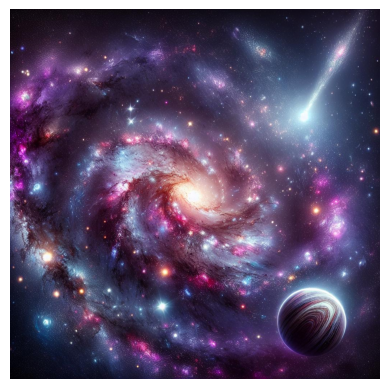

Dalle Assistant Message: c:\gitrepos\aoai-assistants-api-simon\temp.jpg
Proxy Assistant Message: Here is the image of space that you requested:

![Space](sandbox:/c:\gitrepos\aoai-assistants-api-simon\temp.jpg)
Vision Assistant Message: This image is a beautiful depiction of a galaxy with a vibrant mix of colors and stars. The swirling patterns of the galaxy are well defined, and the addition of the comet and planet in the foreground adds depth to the composition. The color palette is rich, with shades of purple, blue, pink, and white that create a cosmic and mystical atmosphere. The image exudes a sense of wonder and the vastness of space.

However, one critique could be that the image may appear too artificial or digitally enhanced, potentially detracting from a realistic portrayal of space. The brightness and saturation of colors could be toned down slightly to provide a more authentic view of a galaxy. Additionally, while the image has good composition, the placement of the planet 

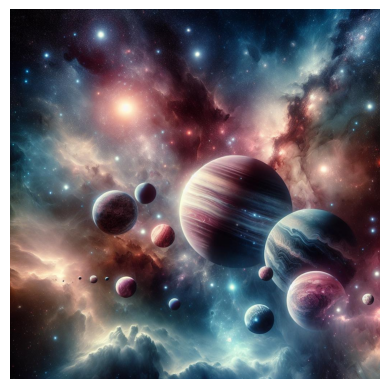

Dalle Assistant Message: c:\gitrepos\aoai-assistants-api-simon\temp.jpg
Proxy Assistant Message: The enhanced image of space with a more realistic color palette, lower color saturation, and a balanced composition is ready:

![Enhanced Space](sandbox:/c:\gitrepos\aoai-assistants-api-simon\temp.jpg)
Vision Assistant Message: The image depicts a stunning cosmic scene with a variety of planets of different sizes and colors set against a backdrop of star-studded nebulae and clouds. The artist has successfully created a sense of depth and scale, with the larger planets appearing closer to the viewer and the smaller ones fading into the distance. The color palette used is vibrant and creates a sense of wonder and awe.

However, there are a few areas where the image could be improved. For example, the composition of the planets seems a bit random and lacks a focal point. The lighting on some of the planets could be more consistent to create a more cohesive look. Additionally, the image could b

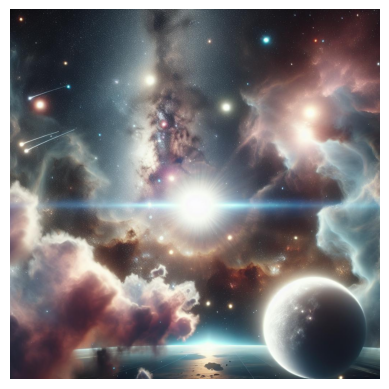

Dalle Assistant Message: c:\gitrepos\aoai-assistants-api-simon\temp.jpg
Proxy Assistant Message: The further enhanced image of space with a clear focal point, consistent lighting across elements, and detailed realistic textures on nebulae is now ready for you to view:

![Further Enhanced Space](sandbox:/c:\gitrepos\aoai-assistants-api-simon\temp.jpg)
Vision Assistant Message: Analysis and Criticism:
The image depicts a cosmic scene with a brilliant central star casting light onto a nearby planet. The surrounding nebulae and dust clouds give a sense of depth and vastness to the space environment. The contrasting colors and the illumination from various celestial bodies create a dramatic effect. The composition of the image is balanced, with the bright star and the planet anchoring the scene.

However, some aspects of the image may benefit from refinement. The star's lens flare appears slightly artificial and could be toned down for a more natural effect. The nebulae, while beautifully r

Exception: ('Run Failed. Error: ', LastError(code='server_error', message='Sorry, something went wrong.'))

In [13]:
thread = client.beta.threads.create()

#Initiate proxy agent and the main thread. This thread will remain active until the task is completed and will serve as the main communication thread between the other agents.
user_message = input("User Query: ")
message = dispatch_message(user_message, user_proxy, thread)